In [1]:
import os
import pandas as pd
from pandas import ExcelWriter
from pandas import ExcelFile
import sys
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.path as pth
from PIL.Image import *
from matplotlib import cm
from PIL import Image
import cv2
from PIL import Image
from sklearn.cluster import KMeans

In [2]:
import sys
import os
print(os.path.dirname(sys.executable))

C:\Anaconda


Time measuring :https://pynash.org/2013/03/06/timing-and-profiling/

## XY image

## Pre-processing

In [3]:
def multiple_imshow(rows,cols,images ,titles):

    plt.figure(len(images), figsize=(12, 12))
    for i in range(len(images)):
        plt.subplot(rows,cols,i+1)
        plt.imshow(images[i],'gray')
        plt.title(titles[i])
        #plt.xticks([]),plt.yticks([]) 
    plt.show()

def defect_detection(path,lower_bound,upper_bound,lower_bound_1 = [0,0,0],upper_bound_1 =[0,0,0]):
    
    img = cv2.imread(path,1)  # BGR color image reading and 0 flag for gray
    
    #blur = cv2.GaussianBlur(img,(5,5),0) #not good results
    #kernel = np.ones((5,5),np.float32)/25 #averaging is not satisfying as well
    #dst = cv2.filter2D(img,-1,kernel)
    #median = cv2.medianBlur(img,5)#median as well
    
    # converting it into Hue, saturation, value (HSV)
    hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
   
    '''Threshold'''
    
    # define range of red color in HSV
    lower = np.array(lower_bound)
    upper = np.array(upper_bound)
    
    # Threshold the HSV image to get only red colors
    mask_0 = cv2.inRange(hsv, lower, upper)
    mask_1 = cv2.inRange(hsv,np.array(lower_bound_1),np.array(upper_bound_1))
    mask =mask_0 + mask_1
    
    # Bitwise-AND mask and original image
    res = cv2.bitwise_and(img,img, mask = mask)
    
    return res


def pre_shaping(image,resol = [284,348]):
    
    #width = resol[1]
    #height = resol[0]
    #dim = (width, height) 
    
    # resize image
    #resized = cv2.resize(image, dim, interpolation = cv2.INTER_AREA)#INTER_LINEAR_EXACT) 
    
    img = image
    rows,cols = img.shape
    
    frame = [[0,0],[cols,0],[0,rows],[cols,rows]]
    dimension = [[0,0],[resol[1],0],[0,resol[0]],[resol[1],resol[0]]]

    pts1 = np.float32(frame)
    pts2 = np.float32(dimension)

    M = cv2.getPerspectiveTransform(pts1,pts2)
    resized = cv2.warpPerspective(img,M,(resol[1],resol[0]))
    
    return resized

def real_shaping(normalized_image,rows_dim,cols_dim,i = 8,j = 17):
    
    img = normalized_image
    rows,cols = img.shape
    
    frame = [[i,j],[rows,j],[i,cols],[rows,cols]]
    dimension = [[0,0],[cols_dim,0],[0,rows_dim],[cols_dim,rows_dim]]

    pts1 = np.float32(frame)
    pts2 = np.float32(dimension)

    M = cv2.getPerspectiveTransform(pts1,pts2)

    real_shape = cv2.warpPerspective(img,M,(cols_dim,rows_dim))
    
    return real_shape

In [4]:
#%reset -f

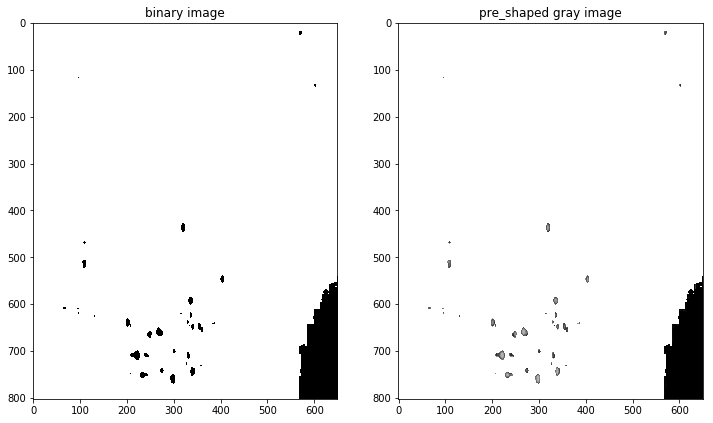

In [5]:
'''Functions call'''

path = "C:/Users/elh/Desktop/xy.png"

''' Big defects : red_yellow'''

lower_bound = [0,0,0]
upper_bound = [55,255,255] # for more defects the upper bound can go till ~105

res = defect_detection(path,lower_bound,upper_bound,[155,0,0],[179,255,255])

"""Binary image to detect the center"""
imgray = cv2.cvtColor(res,cv2.COLOR_BGR2GRAY) #convert to gray

#binary thresholding 
ret,thresh = cv2.threshold(imgray,0,1,cv2.THRESH_BINARY)
#th2 = cv2.adaptiveThreshold(imgray,255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C,\
            #cv2.THRESH_BINARY,11,2) #consider some defects as noise


title = 'Global Thresholding (big defects)'

'''shaping'''
#gray image

#img = pre_shaping(img,resol = [350,285])
images = [255-thresh,255-imgray]#255-img]#i,j --> y,x
titles = ['binary image','pre_shaped gray image']

multiple_imshow(1,2,images ,titles)


In [6]:
pre_processed_img = imgray # pre_shaped gray image

## Processing

In [7]:
def add_neighbours_in_stack(image, a, b, stack, i, j, inComponent):

    inComponent[i, j] = True
    neighbours = [(i+1,j),(i-1,j),(i,j-1),(i,j+1)]
    #neighbours = [(i-1,j-1),(i+1,j-1),(i+1,j),(i-1,j),(i,j-1),(i,j+1),(i-1,j+1),(i+1,j+1)]
    for (k,l) in neighbours:
        if 0<=k<image.shape[0] and 0<=l<image.shape[1]:
            if (image[k,l]>a and image[k,l]<b) and not inComponent[k, l]:
                inComponent[k, l] = True
                stack.append((k,l))
    return 

def connected_component_nb(image, seuil, i0,j0, inComponent):
    stack = [(i0,j0)]
    defect = []
    nb=1
    barycentre = [i0,j0]
    while len(stack)>0:
        (i,j) = stack.pop()
        nb+=1  
        add_neighbours_in_stack(image, seuil, 260, stack, i, j, inComponent)
        
        defect.append((i,j))
        barycentre[0] += i
        barycentre[1] += j
            
    barycentre[0] /= nb
    barycentre[1] /= nb
    
    return nb, barycentre,defect


def all_connected_components(image, seuil):

    inComponent = np.empty(image.shape, dtype=np.bool)
    inComponent[:, :] = False # stoping test

    baryAndSizes = []
    for i in range(image.shape[0]):
        for j in range(image.shape[1]):
            if image[i,j]>seuil and not inComponent[i,j]:
                baryAndSizes.append(connected_component_nb(image,seuil,i,j,inComponent))
                
    return baryAndSizes


def step2(image,defect_nb,thresh):
    
    imageR = image
    imageB = image

    baryAndSizesR = all_connected_components(imageR, thresh)
    baryAndSizesB = all_connected_components(imageB, thresh)
    
    xR, xB = np.array([],dtype=int), np.array([],dtype=int)
    yR, yB = np.array([],dtype=int), np.array([],dtype=int)
    sizeR, sizeB = np.array([]), np.array([]) 
    
    for i in range(len(baryAndSizesR)):
        xR = np.append(xR, baryAndSizesR[i][1][0])
        yR = np.append(yR, baryAndSizesR[i][1][1])
        sizeR = np.append(sizeR, baryAndSizesR[i][0])
    
    for i in range(len(baryAndSizesB)):
        xB = np.append(xB, baryAndSizesB[i][1][0])
        yB = np.append(yB, baryAndSizesB[i][1][1])
        sizeB = np.append(sizeB, baryAndSizesB[i][0])
    
    '''plot'''
    fig, ax = plt.subplots(1,3, figsize = (22,12))
    fig.suptitle('Results', fontsize=16)
    ax[0].set_xlim(0,imageR.shape[1])
    ax[1].set_xlim(0,imageB.shape[1])
    ax[2].set_xlim(0,imageB.shape[1])
    
    title = ['Detected defects centers','Detected defects as discs']
    ax[0].imshow(255-imageR, cmap='gray', vmin = 0, vmax = 255,)
    ax[0].scatter(yR, xR, marker='+', s=sizeR, c = 'r', alpha = 0.5)
    ax[0].set_title(title[0])
    
    ax[0].set_xlabel('x')
    ax[0].set_ylabel('y')

    ax[1].imshow(255-imageB, cmap='gray', vmin = 0, vmax = 255,)
    ax[1].scatter(yB, xB, marker='o', s=sizeB, c = 'b', alpha = 0.5)
    ax[1].set_title(title[1])
    
    ax[1].set_xlabel('x')
    ax[1].set_ylabel('y')
    
    '''defects list''' 
    #print(baryAndSizesB[0][2])#exemple of defect 0
    test = np.array([],dtype=int)
    test = baryAndSizesB[defect_nb][2] #i.e defect number 10
    test_x = np.ndarray(len(test))
    test_y = np.ndarray(len(test))
    for i in range(len(test)):
        test_x[i] = test[i][1] #x axis
        test_y[i] = test[i][0] #y axis
    
    ax[2].imshow(255-imageR, cmap='gray', vmin = 0, vmax = 255,)
    ax[2].scatter(test_x, test_y, marker='o', s=1, c = 'b', alpha = 0.5)

    test = np.stack((test_x, image.shape[0]-test_y), axis=1)
    
    plt.show()
    
    return yR, image.shape[0]-xR, sizeR,test

In [8]:
'''smoothing for noise elimination'''
image = pre_processed_img
blur = cv2.GaussianBlur(image,(5,5),0) 

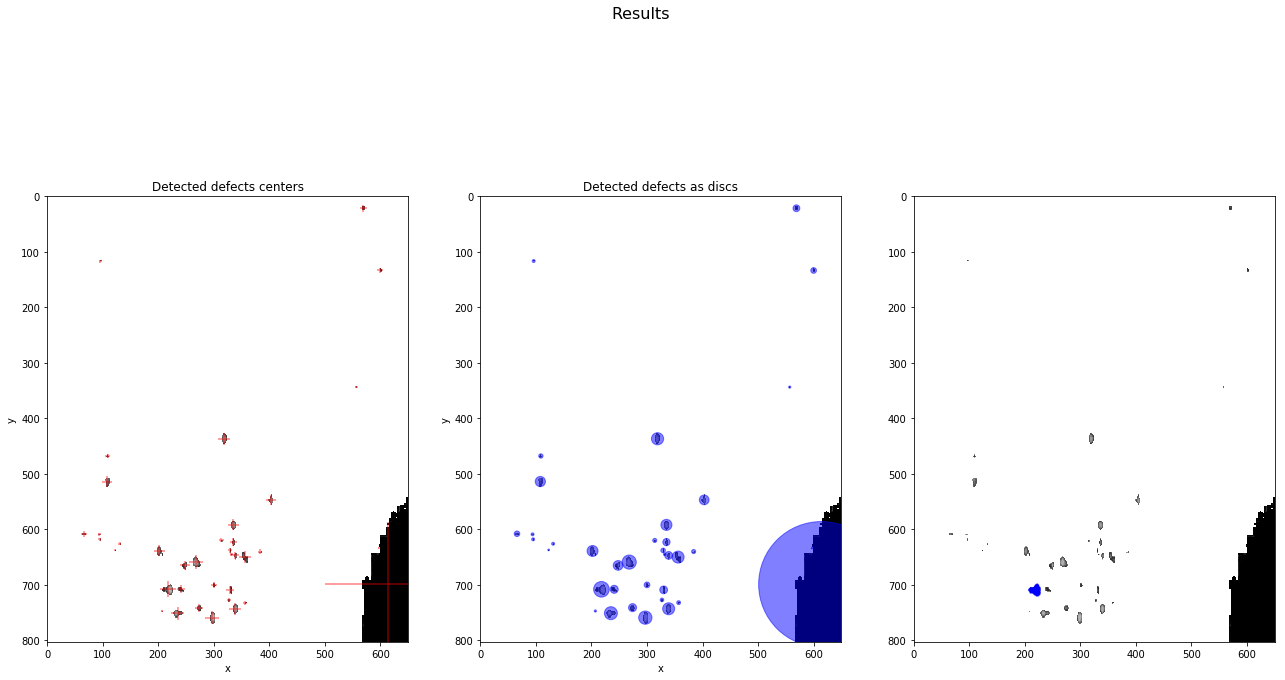

37


In [9]:
'''Call function'''
image = pre_processed_img
#image = blur #gaussian filter
#x, y,area ,test1= step2(image,11,0)
#x, y,area ,test2= step2(image,10,0)
#x, y,area ,test3= step2(image,20,0)
x, y,area ,test= step2(image,27,0)
xy = np.stack((x, y), axis=1)
print len(x)


In [10]:
from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from mpl_toolkits.axes_grid1.inset_locator import mark_inset

'''zoom function'''
def zoom(img,X,Y):
    
    """plot error"""
    f, ax = plt.subplots(1, figsize=(10,6))
    ax.imshow(255-img,cmap='gray')
    
    """zoom"""
    axins = zoomed_inset_axes(ax, 20, loc=3, bbox_to_anchor=(0,0))
    mark_inset(ax, axins, loc1=4, loc2=4, fc="none", ec="0.5")
    axins.set_xlim(X)
    axins.set_ylim(Y)
    
    plt.xticks(visible=False)
    plt.yticks(visible=False)

    """Plot zoom window"""
    axins.imshow(255-img,cmap='gray')
    
    plt.draw()
    plt.savefig("testondefect.jpg", dpi=150)
    plt.show()

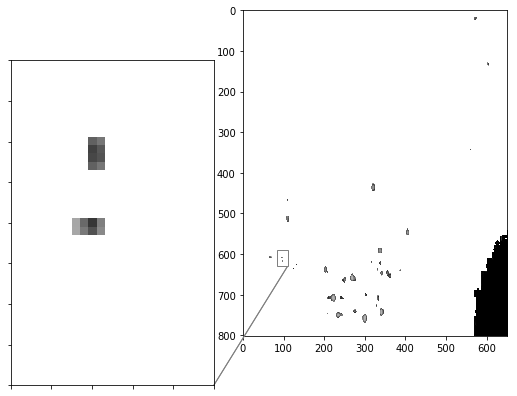

In [11]:
zoom(image,[85,110],[590,630])

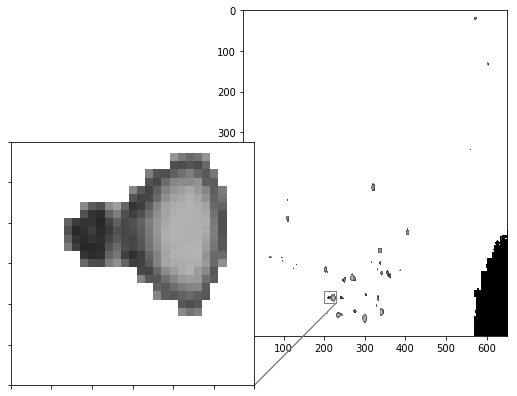

In [12]:
zoom(image,[200,230],[690,720])

In [13]:
def get_defect_intensity(img,defect): #pixel should np.array (x,y)
    
    defect = np.array(defect,dtype=np.uint64)
    intensity = img[img.shape[0]-defect[:,1],defect[:,0]]
    
    return intensity

In [14]:
np.array(test)
test

array([[221., 104.],
       [222., 104.],
       [223., 104.],
       [223., 103.],
       [223., 102.],
       [224., 102.],
       [224., 101.],
       [224., 100.],
       [225., 100.],
       [225.,  99.],
       [225.,  98.],
       [226.,  98.],
       [226.,  97.],
       [226.,  96.],
       [225.,  96.],
       [224.,  96.],
       [223.,  96.],
       [222.,  96.],
       [221.,  96.],
       [220.,  96.],
       [219.,  96.],
       [218.,  96.],
       [217.,  96.],
       [216.,  96.],
       [215.,  96.],
       [214.,  96.],
       [213.,  96.],
       [212.,  96.],
       [211.,  96.],
       [210.,  96.],
       [209.,  96.],
       [208.,  96.],
       [207.,  96.],
       [207.,  95.],
       [207.,  94.],
       [208.,  94.],
       [209.,  94.],
       [210.,  94.],
       [211.,  94.],
       [212.,  94.],
       [213.,  94.],
       [214.,  94.],
       [215.,  94.],
       [216.,  94.],
       [217.,  94.],
       [218.,  94.],
       [219.,  94.],
       [220.,

In [15]:
defect = test

In [16]:
defect.shape

(244L, 2L)

#### slice of defect to seperate

In [17]:
defect = test
defect = np.array(defect,dtype=np.uint64)

In [18]:
get_defect_intensity(imgray,defect).shape

(244L,)

In [19]:
i_min = np.min(imgray.shape[0]-defect[:,1])
i_max = np.max(imgray.shape[0]-defect[:,1]+1)
j_min = np.min(defect[:,0])
j_max = np.max(defect[:,0]+1)

In [20]:
imgray[i_min:i_max,j_min:j_max][imgray[i_min:i_max,j_min:j_max]!= 0].shape\
== get_defect_intensity(imgray,defect).shape

True

In [21]:
case_0 = imgray[i_min:i_max,j_min:j_max]
df = pd.DataFrame(case_0)
df

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,118,139,127,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,169,176,168,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,122,162,168,158,150,160,169,0,0
3,0,0,0,0,0,0,0,0,0,0,0,157,164,147,131,124,120,163,0,0
4,0,0,0,0,0,0,0,0,0,123,168,168,143,120,102,97,102,144,162,0
5,0,0,0,0,0,0,0,0,0,181,186,152,116,99,85,76,99,119,167,0
6,0,0,151,178,180,131,111,154,192,190,164,125,91,85,83,79,82,101,150,112
7,0,0,201,210,207,155,136,191,207,191,156,123,90,78,77,77,75,107,149,149
8,132,193,215,215,211,172,148,177,186,171,140,113,87,82,79,75,77,98,138,168
9,155,204,212,202,208,186,164,182,186,168,137,110,82,76,79,81,78,93,132,168


####  Find minima

In [22]:
case_0
minima_1 = np.where((case_0 == 75))
minima_2 = np.where((case_0 == 136))

a = np.array(minima_1).T
b = np.array(minima_2).T
b

array([[7, 6]], dtype=int64)

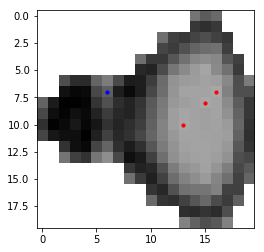

In [23]:
plt.imshow(255-case_0,cmap='gray')
plt.scatter(b[0,1], b[0,0], marker='o', s=10, c = 'b', alpha = 1)
plt.scatter(a[:,1], a[:,0], marker='o', s=10, c = 'r', alpha = 1)
plt.show()

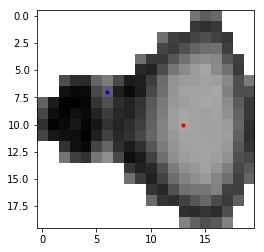

In [24]:
plt.imshow(255-case_0,cmap='gray')
plt.scatter(b[0,1], b[0,0], marker='o', s=10, c = 'b', alpha = 1)
plt.scatter(a[2,1], a[2,0], marker='o', s=10, c = 'r', alpha = 1)
plt.show()

### Watershed algo

In [25]:
def add_neighbours_in_stack(image, a, b, stack, i, j, inComponent):

    inComponent[i, j] = True
    #neighbours = [(i+1,j),(i-1,j),(i,j-1),(i,j+1)]
    neighbours = [(i-1,j-1),(i+1,j-1),(i+1,j),(i-1,j),(i,j-1),(i,j+1),(i-1,j+1),(i+1,j+1)]
    for (k,l) in neighbours:
        if 0<=k<image.shape[0] and 0<=l<image.shape[1]:
            if (image[k,l]>a and image[k,l]<b) and not inComponent[k, l]:
                inComponent[k, l] = True
                stack.append((k,l))
    return 

def connected_component_nb(image, seuil, i0,j0, inComponent):
    stack = [(i0,j0)]
    defect = []
    nb=1
    barycentre = [i0,j0]
    while len(stack)>0:
        (i,j) = stack.pop()
        nb+=1  
        add_neighbours_in_stack(image, seuil, 135, stack, i, j, inComponent)
        
        defect.append([(i,j)])
        barycentre[0] += i
        barycentre[1] += j
            
    barycentre[0] /= nb
    barycentre[1] /= nb
    
    return nb, barycentre,defect


def all_connected_components(image, seuil):

    inComponent = np.empty(image.shape, dtype=np.bool)
    inComponent[:, :] = False # stoping test

    baryAndSizes = []
    #for i in range(image.shape[0]):
        #or j in range(image.shape[1]):
            #if (image[i,j]>seuil and image[i,j]<135)  and not inComponent[i,j]:
    baryAndSizes.append(connected_component_nb(image,seuil,10,15,inComponent))
                
    return baryAndSizes


def watershed(image,thresh):
    
    baryAndSizesR = all_connected_components(image, thresh)

    x, y = np.array([],dtype=int), np.array([],dtype=int)
    size = np.array([])
    defect = np.array([])
    
    for i in range(len(baryAndSizesR)):
        x = np.append(x, baryAndSizesR[i][1][0])
        y = np.append(y, baryAndSizesR[i][1][1])
        size = np.append(size, baryAndSizesR[i][0])
        defect = np.append(defect, baryAndSizesR[i][2])
    
    
    '''plot'''
    fig, ax = plt.subplots(1,2, figsize = (22,12))
    fig.suptitle('Results', fontsize=16)
    ax[0].set_xlim(0,image.shape[1])
    ax[1].set_xlim(0,image.shape[1])
    #ax[2].set_xlim(0,imageB.shape[1])
    
    title = ['Detected defects centers','Detected defects as discs']
    ax[0].imshow(255-image, cmap='gray', vmin = 0, vmax = 255,)
    ax[0].scatter(y, x, marker='+', s=size, c = 'r', alpha = 0.5)
    ax[0].set_title(title[0])
    
    ax[0].set_xlabel('x')
    ax[0].set_ylabel('y')

    ax[1].imshow(255-image, cmap='gray', vmin = 0, vmax = 255,)
    ax[1].scatter(y, x, marker='o', s=size, c = 'b', alpha = 0.5)
    ax[1].set_title(title[1])
    
    ax[1].set_xlabel('x')
    ax[1].set_ylabel('y')
    

    
    plt.show()
    
    return y, image.shape[0]-x, size,defect

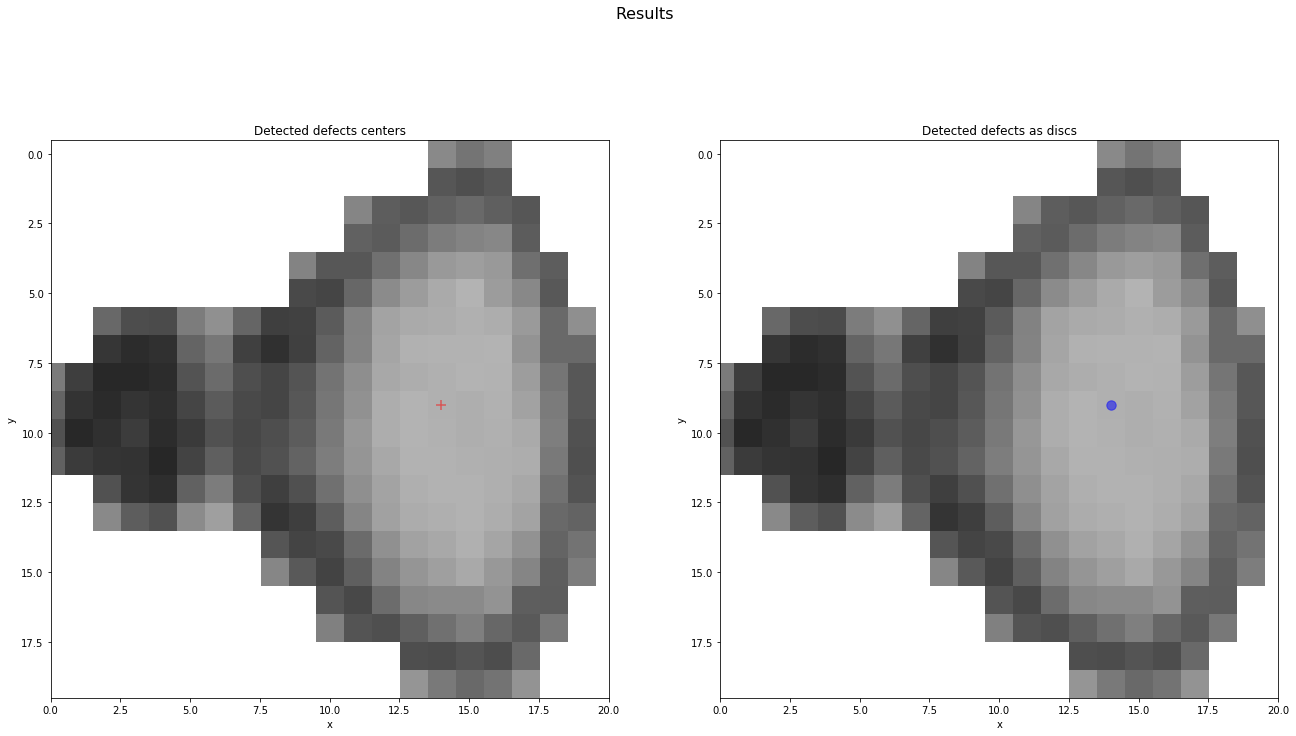

In [26]:
y, x, size,defect = watershed(case_0,75)



In [27]:
size, x, y, defect

(array([89.]),
 array([11]),
 array([14]),
 array([10., 15., 11., 16., 12., 17., 11., 18., 10., 18.,  9., 18.,  8.,
        17.,  8., 16.,  7., 15.,  6., 16.,  5., 17.,  4., 16.,  4., 15.,
         4., 14.,  4., 13.,  5., 12.,  6., 13.,  7., 13.,  8., 13.,  9.,
        13., 10., 12., 11., 13., 12., 14., 13., 15., 14., 16., 15., 17.,
        16., 16., 16., 15., 16., 14., 16., 13., 15., 12., 14., 13., 13.,
        12., 13., 11., 12., 11., 11., 10., 10., 10., 14., 12., 15., 13.,
        15., 14., 17., 15., 14., 17., 15., 16., 15., 15., 14., 15., 14.,
        14., 13., 14., 13., 13., 12., 13., 12., 12., 10., 11., 11., 12.,
        11., 11.,  9., 11.,  8., 11.,  7., 11.,  9., 12.,  8., 12.,  7.,
        12.,  6., 12.,  6., 11.,  5., 13.,  5., 14.,  3., 14.,  3., 16.,
         3., 15.,  6., 17.,  5., 16.,  5., 15.,  7., 14.,  6., 15.,  8.,
        14.,  6., 14.,  7., 17.,  9., 17., 13., 17., 13., 16., 10., 17.,
        11., 17., 12., 16., 12., 15.,  9., 16., 10., 16., 10., 14.,  9.,
        

In [28]:
defect.shape[0]/2.

88.0

In [29]:
defect_r = defect.reshape(defect.shape[0]/2,2)

In [30]:
defect_r.shape

(88L, 2L)

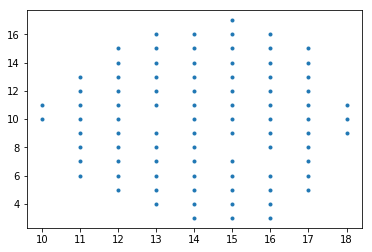

In [31]:
plt.plot(defect_r[:,1],defect_r[:,0],'.')
plt.show()

In [32]:
case_0[10,15]

81

In [33]:
def add_neighbours_in_stack(image, a, b, stack, i, j, inComponent):

    inComponent[i, j] = True
    #neighbours = [(i+1,j),(i-1,j),(i,j-1),(i,j+1)]
    neighbours = [(i-1,j-1),(i+1,j-1),(i+1,j),(i-1,j),(i,j-1),(i,j+1),(i-1,j+1),(i+1,j+1)]
    for (k,l) in neighbours:
        if 0<=k<image.shape[0] and 0<=l<image.shape[1]:
            if (image[k,l]>a and image[k,l]<b) and not inComponent[k, l]:
                inComponent[k, l] = True
                stack.append((k,l))
    return 

def connected_component_nb(image, seuil, i0,j0, inComponent):
    stack = [(i0,j0)]
    defect = []
    nb=1
    barycentre = [i0,j0]
    while len(stack)>0:
        (i,j) = stack.pop()
        nb+=1  
        add_neighbours_in_stack(image, seuil, 255, stack, i, j, inComponent)
        
        defect.append([(i,j)])
        barycentre[0] += i
        barycentre[1] += j
            
    barycentre[0] /= nb
    barycentre[1] /= nb
    
    return nb, barycentre,defect


def all_connected_components(image, seuil):

    inComponent = np.empty(image.shape, dtype=np.bool)
    inComponent[:, :] = False # stoping test

    baryAndSizes = []
    #for i in range(image.shape[0]):
        #or j in range(image.shape[1]):
            #if (image[i,j]>seuil and image[i,j]<135)  and not inComponent[i,j]:
    baryAndSizes.append(connected_component_nb(image,seuil,8,6,inComponent))
                
    return baryAndSizes


def watershed(image,thresh):
    
    baryAndSizesR = all_connected_components(image, thresh)

    x, y = np.array([],dtype=int), np.array([],dtype=int)
    size = np.array([])
    defect = np.array([])
    
    for i in range(len(baryAndSizesR)):
        x = np.append(x, baryAndSizesR[i][1][0])
        y = np.append(y, baryAndSizesR[i][1][1])
        size = np.append(size, baryAndSizesR[i][0])
        defect = np.append(defect, baryAndSizesR[i][2])
    
    
    '''plot'''
    fig, ax = plt.subplots(1,2, figsize = (22,12))
    fig.suptitle('Results', fontsize=16)
    ax[0].set_xlim(0,image.shape[1])
    ax[1].set_xlim(0,image.shape[1])
    
    title = ['Detected defects centers','Detected defects as discs']
    ax[0].imshow(255-image, cmap='gray', vmin = 0, vmax = 255,)
    ax[0].scatter(y, x, marker='+', s=size, c = 'r', alpha = 0.5)
    ax[0].set_title(title[0])
    
    ax[0].set_xlabel('x')
    ax[0].set_ylabel('y')

    ax[1].imshow(255-image, cmap='gray', vmin = 0, vmax = 255,)
    ax[1].scatter(y, x, marker='o', s=size, c = 'b', alpha = 0.5)
    ax[1].set_title(title[1])
    
    ax[1].set_xlabel('x')
    ax[1].set_ylabel('y')
    

    
    plt.show()
    
    return y, image.shape[0]-x, size,defect

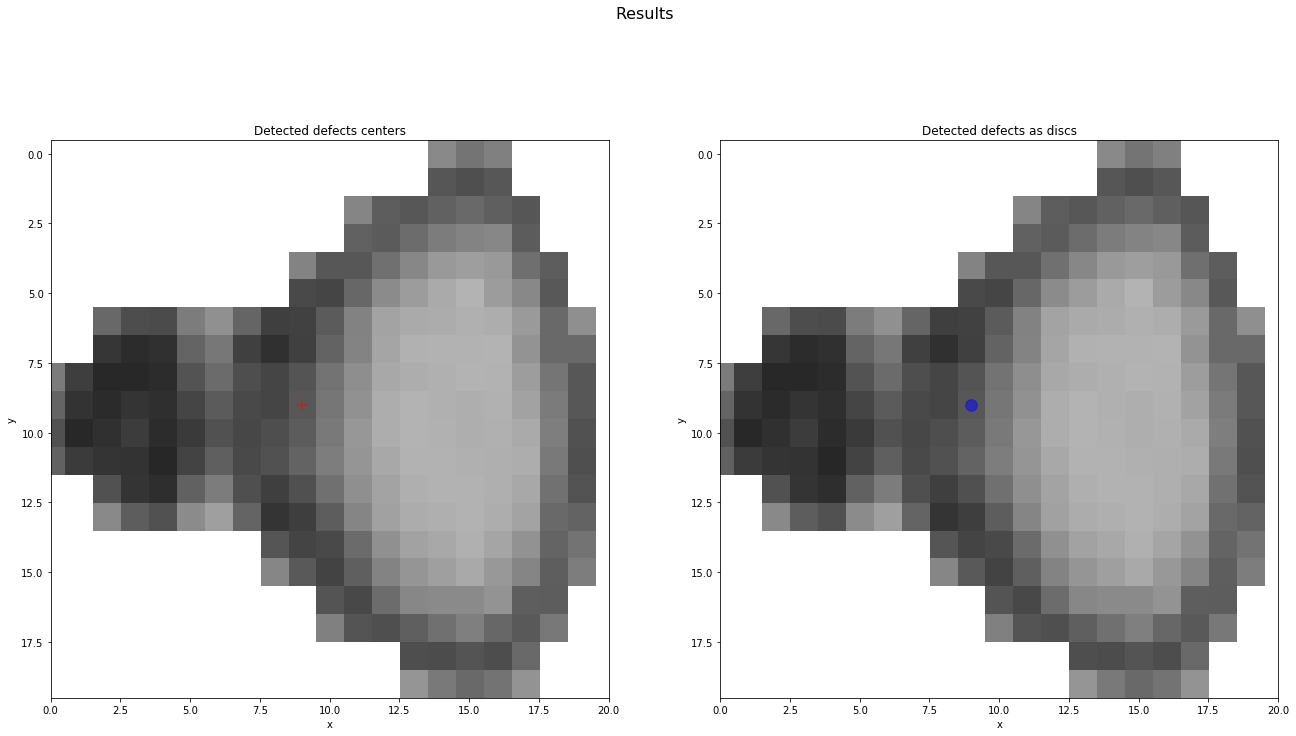

In [34]:
y, x, size,defect = watershed(case_0,135)

In [35]:
size, x, y, defect

(array([135.]),
 array([11]),
 array([9]),
 array([ 8.,  6.,  9.,  7., 10.,  8., 11.,  9., 12., 10., 13., 10., 14.,
        11., 15., 11., 16., 12., 17., 13., 18., 14., 19., 15., 18., 16.,
        17., 17., 16., 18., 15., 18., 14., 19., 13., 19., 12., 19., 11.,
        19., 10., 19.,  9., 19.,  8., 19.,  7., 19.,  6., 18.,  5., 18.,
         4., 18.,  3., 17.,  2., 17.,  1., 16.,  1., 15.,  1., 14.,  2.,
        13.,  2., 12.,  3., 11.,  4., 12.,  5., 11.,  5., 10.,  5.,  9.,
         6.,  8.,  7.,  9.,  8., 10.,  9., 10.,  7., 10.,  8.,  9.,  6.,
         7.,  7.,  8.,  6.,  9.,  6., 10.,  4., 11.,  4., 10.,  3., 13.,
         3., 12.,  2., 14.,  2., 15.,  0., 15.,  2., 16.,  4., 17.,  7.,
        18.,  8., 18., 12., 18., 13., 18., 14., 18., 16., 17., 18., 17.,
        17., 16., 19., 16., 18., 15., 17., 14., 18., 13., 17., 12., 17.,
        11., 16., 11., 16., 10., 15.,  9., 14.,  8., 13.,  8., 12.,  7.,
        11.,  6., 11.,  5., 11.,  4., 11.,  3., 11.,  2., 11.,  1., 11.,
        

In [36]:
defect_l = defect.reshape(defect.shape[0]/2,2)

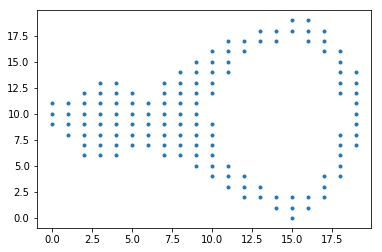

In [37]:
plt.plot(defect_l[:,1],defect_l[:,0],'.')
plt.show()

In [38]:
def add_neighbours_in_stack(image, a, b, stack, i, j, inComponent):

    inComponent[i, j] = True
    #neighbours = [(i+1,j),(i-1,j),(i,j-1),(i,j+1)]
    neighbours = [(i-1,j-1),(i+1,j-1),(i+1,j),(i-1,j),(i,j-1),(i,j+1),(i-1,j+1),(i+1,j+1)]
    for (k,l) in neighbours:
        if 0<=k<image.shape[0] and 0<=l<image.shape[1]:
            if (image[k,l]>a and image[k,l]<b) and not inComponent[k, l]:
                inComponent[k, l] = True
                stack.append((k,l))
    return 

def connected_component_nb(image, seuil, i0,j0, inComponent):
    stack = [(i0,j0)]
    defect = []
    nb=1
    barycentre = [i0,j0]
    while len(stack)>0:
        (i,j) = stack.pop()
        nb+=1  
        add_neighbours_in_stack(image, seuil, 255, stack, i, j, inComponent)
        
        defect.append([(i,j)])
        barycentre[0] += i
        barycentre[1] += j
            
    barycentre[0] /= nb
    barycentre[1] /= nb
    
    return nb, barycentre,defect


def all_connected_components(image, seuil):

    inComponent = np.empty(image.shape, dtype=np.bool)
    inComponent[:, :] = False # stoping test

    baryAndSizes = []
    #for i in range(image.shape[0]):
    for i,j in [(10,15),(8,6)]:
            #if (image[i,j]>seuil and image[i,j]<135)  and not inComponent[i,j]:
        baryAndSizes.append(connected_component_nb(image,seuil,i,j,inComponent))
                
    return baryAndSizes


def watershed(image,thresh):
    
    baryAndSizesR = all_connected_components(image, thresh)

    x, y = np.array([],dtype=int), np.array([],dtype=int)
    size = np.array([])
    defect = np.array([])
    
    for i in range(len(baryAndSizesR)):
        x = np.append(x, baryAndSizesR[i][1][0])
        y = np.append(y, baryAndSizesR[i][1][1])
        size = np.append(size, baryAndSizesR[i][0])
        defect = np.append(defect, baryAndSizesR[i][2])
    
    
    '''plot'''
    fig, ax = plt.subplots(1,2, figsize = (22,12))
    fig.suptitle('Results', fontsize=16)
    ax[0].set_xlim(0,image.shape[1])
    ax[1].set_xlim(0,image.shape[1])
    
    title = ['Detected defects centers','Detected defects as discs']
    ax[0].imshow(255-image, cmap='gray', vmin = 0, vmax = 255,)
    ax[0].scatter(y, x, marker='+', s=size, c = 'r', alpha = 0.5)
    ax[0].set_title(title[0])
    
    ax[0].set_xlabel('x')
    ax[0].set_ylabel('y')

    ax[1].imshow(255-image, cmap='gray', vmin = 0, vmax = 255,)
    ax[1].scatter(y, x, marker='o', s=size, c = 'b', alpha = 0.5)
    ax[1].set_title(title[1])
    
    ax[1].set_xlabel('x')
    ax[1].set_ylabel('y')
    

    
    plt.show()
    
    return y, image.shape[0]-x, size,defect

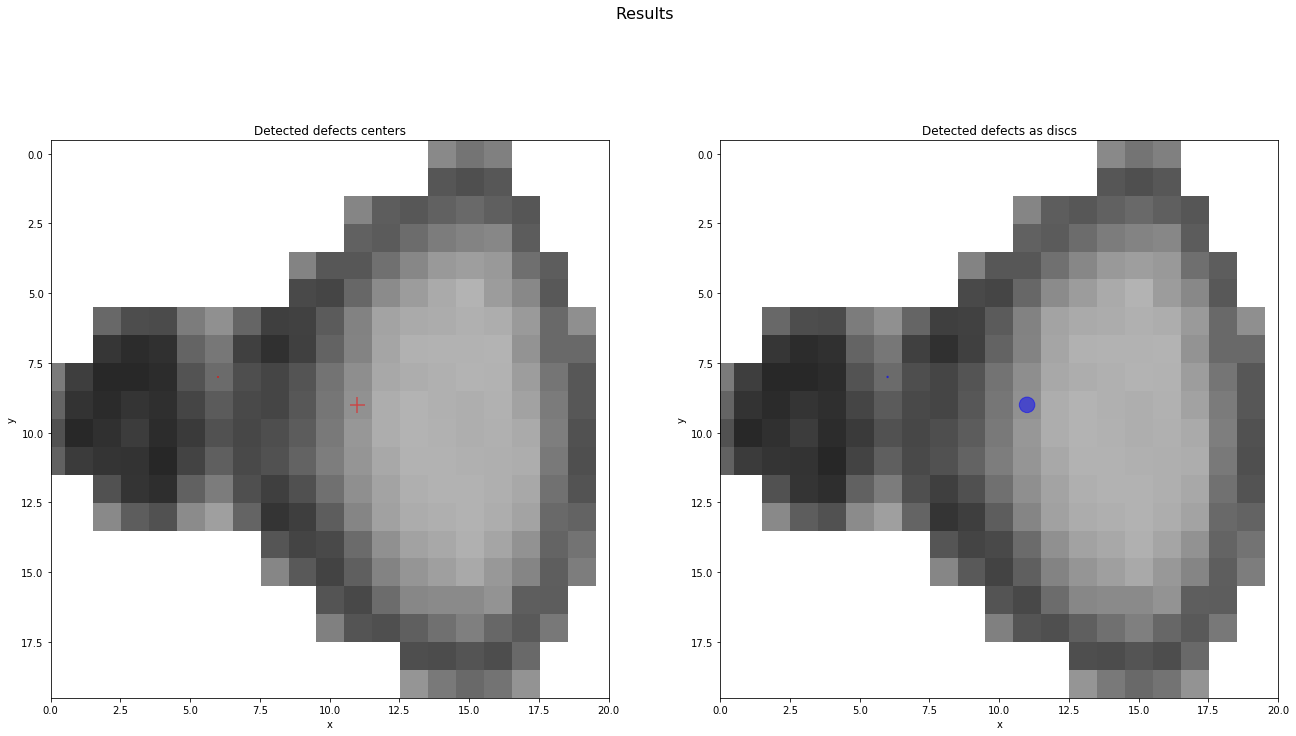

In [39]:
y, x, size,defect = watershed(case_0,75)

In [40]:
defect

array([10., 15., 11., 16., 12., 17., 13., 18., 14., 19., 15., 19., 16.,
       18., 16., 17., 16., 16., 16., 15., 16., 14., 16., 13., 16., 12.,
       16., 11., 16., 10., 15.,  9., 14., 10., 13., 11., 14., 12., 13.,
       13., 14., 14., 13., 15., 14., 16., 14., 15., 12., 14., 11., 13.,
       11., 12., 11., 11., 11., 10., 11.,  9., 11.,  8., 11.,  7., 11.,
        6., 11.,  5., 11.,  4., 11.,  3., 11.,  2., 11.,  1., 11.,  0.,
       10.,  0.,  9.,  1.,  8.,  2.,  9.,  3.,  8.,  4.,  9.,  5.,  8.,
        6.,  9.,  7.,  8.,  8.,  9.,  9.,  8., 10.,  9., 11.,  8., 12.,
        9., 13.,  8., 14.,  7., 15.,  8., 16.,  9., 17., 10., 18., 11.,
       19.,  9., 19.,  8., 19.,  7., 19.,  6., 19.,  5., 18.,  5., 17.,
        5., 16.,  5., 15.,  5., 14.,  5., 13.,  5., 12.,  5., 11.,  5.,
       10.,  5.,  9.,  6.,  8.,  6.,  7.,  6.,  6.,  6.,  5.,  6.,  4.,
        6.,  3.,  6.,  2.,  6.,  9.,  4.,  9.,  6., 10.,  4., 10.,  3.,
       11.,  2., 12.,  3., 13.,  2., 14.,  3., 15.,  2., 16.,  3

In [41]:
defect_all = defect.reshape(defect.shape[0]/2,2)

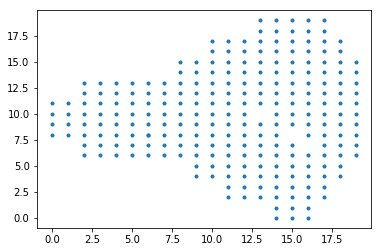

In [42]:
plt.plot(defect_all[:,1],defect_all[:,0],'.')
plt.show()

### Algorithm

In [43]:
case_0 = imgray[i_min:i_max,j_min:j_max]

### 3d plot

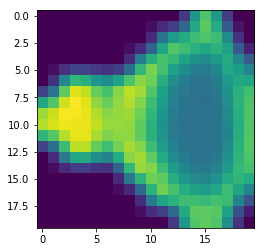

In [44]:
case_0_1 = case_0.copy()
blur = cv2.GaussianBlur(case_0_1,(3,3),0) #not good results
plt.imshow(blur)

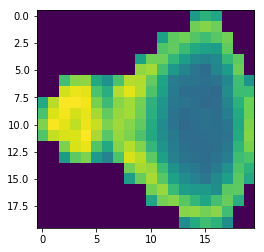

In [45]:
plt.imshow(case_0)

In [46]:
df_blur = pd.DataFrame(blur)
df_blur

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
0,0,0,0,0,0,0,0,0,0,0,0,0,0,36,111,152,113,37,0,0
1,0,0,0,0,0,0,0,0,0,0,8,25,38,70,127,157,129,60,11,0
2,0,0,0,0,0,0,0,0,0,0,25,81,116,129,145,152,145,101,31,0
3,0,0,0,0,0,0,0,0,8,26,66,126,153,145,133,126,134,121,60,20
4,0,0,0,0,0,0,0,0,27,86,132,149,141,122,108,102,113,128,97,61
5,0,9,30,43,42,35,32,38,76,140,168,148,121,102,90,87,98,125,118,95
6,0,31,98,138,132,110,102,122,152,173,164,132,103,88,82,81,88,113,127,124
7,41,80,159,200,190,160,149,172,190,181,154,121,95,83,79,78,84,108,135,146
8,126,153,195,210,200,175,163,176,185,171,144,115,92,81,78,77,82,104,135,151
9,179,193,208,207,202,186,173,177,179,164,138,110,88,79,79,79,82,99,132,151


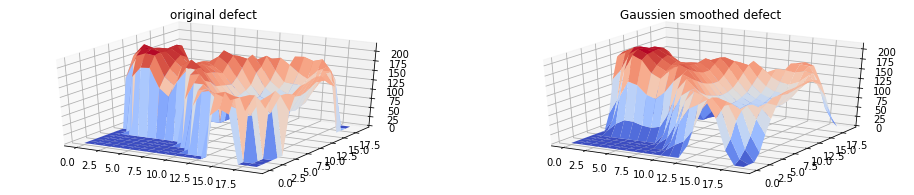

In [47]:
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter

fig = plt.figure(figsize=plt.figaspect(0.2))
ax0 = fig.add_subplot(1, 2, 1, projection='3d')


# Make data.
X = np.arange(0, 20, 1)
Y = np.arange(0, 20, 1)
X, Y = np.meshgrid(X, Y)
Z = (case_0,blur)

# Plot the surface.
surf0 = ax0.plot_surface(X, Y, Z[0], cmap=cm.coolwarm,
                       linewidth=0, antialiased=True)

# Customize the z axis.
#ax0.set_zlim(0, 255)
#ax0.zaxis.set_major_locator(LinearLocator(10))
#ax0.zaxis.set_major_formatter(FormatStrFormatter('%.d'))

# Add a color bar which maps values to colors.

ax1 = fig.add_subplot(1, 2, 2, projection='3d')

surf1 = ax1.plot_surface(X, Y, Z[1], cmap=cm.coolwarm,
                       linewidth=0, antialiased=True)

ax0.set_title('original defect')
ax1.set_title('Gaussien smoothed defect')

plt.show()


In [48]:
case_0= blur.copy()
minima_1 = np.where((case_0 == 80))
minima_2 = np.where((case_0 == 154))

a = np.array(minima_1).T
b = np.array(minima_2).T
minima = zip(a[1,:],b[0,:])
minima

[(10, 7), (15, 10)]

#### step 0 : labeling

In [49]:
min_label = np.min(case_0[np.where(case_0>0)])
max_label = np.max(case_0[np.where(case_0>0)])

min_label
max_label
Hight_step =10

In [50]:
def label(case_0,min_label,max_label,Hight_step):
    Labeled = case_0.copy()
    i = 1
    while ((min_label+Hight_step*i) <= max_label):
        Labeled[np.where((min_label+Hight_step*i>case_0) & (case_0 >=min_label+Hight_step*(i-1)))]= Hight_step*i
        i=i+1

    return Labeled

In [51]:
Labeled = label(blur,min_label,max_label,Hight_step)

In [52]:
df = pd.DataFrame(Labeled)
df

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
0,0,0,0,0,0,0,0,0,0,0,0,0,0,30,110,150,110,40,0,0
1,0,0,0,0,0,0,0,0,0,0,10,20,40,70,130,160,130,60,10,0
2,0,0,0,0,0,0,0,0,0,0,20,80,110,130,140,150,140,100,30,0
3,0,0,0,0,0,0,0,0,10,20,60,120,150,140,130,120,130,120,60,20
4,0,0,0,0,0,0,0,0,30,80,130,150,140,120,110,100,110,130,100,60
5,0,10,30,40,40,30,30,40,70,140,170,150,120,100,90,90,100,120,120,90
6,0,30,100,140,130,110,100,120,150,170,160,130,100,90,80,80,90,110,130,120
7,40,80,160,200,190,160,150,170,190,180,150,120,90,80,80,80,80,110,130,140
8,120,150,190,210,200,170,160,170,180,170,140,110,90,80,80,80,80,100,130,150
9,180,190,208,207,200,180,170,180,180,160,140,110,90,80,80,80,80,100,130,150


### minima 1

####  level 120

In [53]:
minima 

[(10, 7), (15, 10)]

In [54]:
minima

[(10, 7), (15, 10)]

In [55]:
def add_neighbours_in_watershed(Labeled, level, stack, i,j, notwatershed):

    notwatershed[i, j] = True
    neighbours = [(i+1,j),(i-1,j),(i,j-1),(i,j+1)]
    #neighbours = [(i-1,j-1),(i+1,j-1),(i+1,j),(i-1,j),(i,j-1),(i,j+1),(i-1,j+1),(i+1,j+1)]
    for (k,l) in neighbours:
        if 0<=k<Labeled.shape[0] and 0<=l<Labeled.shape[1]:
            if (Labeled[k,l]<=level)and (Labeled[k,l]>0) and not notwatershed[k, l]:
                stack.append((k,l))
                add_neighbours_in_watershed(Labeled, level, stack, k, l, notwatershed)
                
    return notwatershed

In [56]:
notwatershed = np.empty(case_0.shape, dtype=np.bool)
notwatershed[:, :] = False # watershed pixels
stack =[]

In [57]:
#%%timeit
df = pd.DataFrame((add_neighbours_in_watershed(Labeled, 180, stack, 9, 12, notwatershed)))
df*1


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,0,0
1,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1,1,0
2,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1,1,0
3,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1,1,1,1,1
4,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1,1,1,1,1
5,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
6,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
7,1,1,1,0,0,1,1,1,0,1,1,1,1,1,1,1,1,1,1,1
8,1,1,0,0,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
9,1,0,0,0,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1


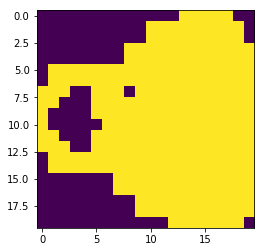

In [58]:
plt.imshow(df)

### minimum 2 

In [59]:
Labeled[minima[1]]

160

In [60]:
def add_neighbours_in_watershed(Labeled, level, stack, i,j, notwatershed):

    notwatershed[i, j] = True
    neighbours = [(i+1,j),(i-1,j),(i,j-1),(i,j+1)]
    #neighbours = [(i-1,j-1),(i+1,j-1),(i+1,j),(i-1,j),(i,j-1),(i,j+1),(i-1,j+1),(i+1,j+1)]
    for (k,l) in neighbours:
        if 0<=k<Labeled.shape[0] and 0<=l<Labeled.shape[1]:
            if (Labeled[k,l]>=level) and not notwatershed[k, l]:
                stack.append((k,l))
                add_neighbours_in_watershed(Labeled, level, stack, k, l, notwatershed)
                
    return notwatershed

In [61]:
notwatershed = np.empty(case_0.shape, dtype=np.bool)
notwatershed[:, :] = False # watershed pixels
stack =[]

In [62]:
df2 = pd.DataFrame(add_neighbours_in_watershed(Labeled, 130, stack, 10, 3, notwatershed))
df2*1

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,0,1,0,0,0
4,0,0,0,0,0,0,0,0,0,0,1,1,1,0,0,0,0,0,0,0
5,0,0,0,0,0,0,0,0,0,1,1,1,0,0,0,0,0,0,0,0
6,0,0,0,1,1,0,0,0,1,1,1,1,0,0,0,0,0,0,1,0
7,0,0,1,1,1,1,1,1,1,1,1,0,0,0,0,0,0,0,1,1
8,0,1,1,1,1,1,1,1,1,1,1,0,0,0,0,0,0,0,1,1
9,1,1,1,1,1,1,1,1,1,1,1,0,0,0,0,0,0,0,1,1


In [63]:
minima

[(10, 7), (15, 10)]

### Minima

In [64]:
notwatershed = np.empty(case_0.shape, dtype=np.bool)
notwatershed[:, :] = False # watershed pixels
stack =[]

In [65]:
def add_neighbours_in_watershed(Labeled, level, stack, i,j, notwatershed):

    notwatershed[i, j] = True
    neighbours = [(i+1,j),(i-1,j),(i,j-1),(i,j+1)]
    #neighbours = [(i-1,j-1),(i+1,j-1),(i+1,j),(i-1,j),(i,j-1),(i,j+1),(i-1,j+1),(i+1,j+1)]
    for (k,l) in neighbours:
        if 0<=k<Labeled.shape[0] and 0<=l<Labeled.shape[1]:
            if (Labeled[k,l]<=level)and (Labeled[k,l]> 0) and not notwatershed[k, l]:
                stack.append((k,l))
                add_neighbours_in_watershed(Labeled, level, stack, k, l, notwatershed)
                
    return notwatershed

In [66]:
for (i,j) in minima:
    notwatershed = add_neighbours_in_watershed(Labeled, 255, stack, i,j, notwatershed)

In [67]:
df0 = pd.DataFrame(notwatershed)
df0*1

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,0,0
1,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1,1,0
2,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1,1,0
3,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1,1,1,1,1
4,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1,1,1,1,1
5,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
6,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
7,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
8,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
9,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1


### separation

In [68]:
np.stack((df*1,df2*1),axis=0)

array([[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [0, 1, 1, 1,

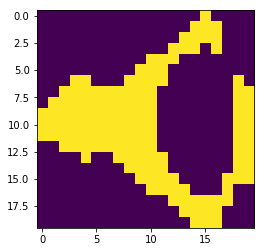

In [69]:
plt.imshow(df2)

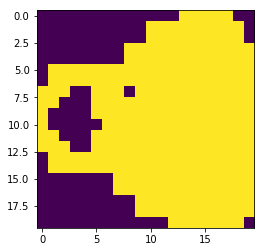

In [70]:
plt.imshow(df)

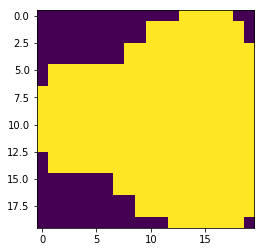

In [71]:
plt.imshow(df0)

## Contour

### Ellipse

In [72]:
case = case_0.copy()

In [73]:
im = np.empty(case.shape, dtype=np.bool)
im[:,:] = 0
im[np.where(case>0)]= 1
im = im*1

In [74]:
ret,thresh = cv2.threshold(case,0,255,0)
contours,hierarchy = cv2.findContours(thresh, 1, 2)

cnt = contours[0]

In [75]:
(x,y),(MA,ma),angle = cv2.fitEllipse(cnt)
#llipse = cv2.fitEllipse(cnt)
#im = cv2.ellipse(case_0,ellipse,(0,255,0),2)
#plt.imshow(im)
(x,y)
(MA,ma)
#angle

(17.514001846313477, 31.838390350341797)

In [76]:
angle = np.angle(-1+1j, deg=True)
angle

135.0

In [77]:
https://carstenschelp.github.io/2018/09/14/Plot_Confidence_Ellipse_001.html
https://matplotlib.org/3.1.0/gallery/units/ellipse_with_units.html#sphx-glr-gallery-units-ellipse-with-units-py

SyntaxError: invalid syntax (<ipython-input-77-ad3738699b92>, line 1)

## Watershed on one single defect study case

## Post-processing

In [78]:
def post_processing(polygon,coordinates,area):
    old_dim = len(coordinates)
    p = pth.Path(polygon)
    mask = p.contains_points(coordinates)
    reduced_coord = coordinates[mask]
    reduced_area = area[mask]
    new_dim = len(reduced_coord)
    print(old_dim-new_dim,' values were reduced')
    return reduced_coord,reduced_area

def resizing(img,reduced_coord,dim):
    
    k_x = np.array(img.shape[1]/dim[0],dtype=float)
    k_y = np.array(img.shape[0]/dim[1],dtype=float)
    
    coord = reduced_coord.copy().astype(float)
    coord[:,0],coord[:,1] = reduced_coord[:,0]/k_x,reduced_coord[:,1]/k_y
    
    return coord
    

In [79]:
image.shape

(803L, 650L)

In [80]:
'''Function call'''
print image.shape
area = area
coordinates = xy
#polygon = np.array([[0,0],[image.shape[1],0],
        #[image.shape[1],image.shape[0]],[0,image.shape[0]]])
    
polygon = np.array([[0,0],[400,0],[image.shape[1],500],
        [image.shape[1],image.shape[0]],[0,image.shape[0]]]) 
                    
reduced_coord,reduced_area = post_processing(polygon,coordinates,area)

(803L, 650L)
(2, ' values were reduced')


In [81]:
'''Read the validation data with pandas'''

filepath="H:/Ali/_Internship/Validation/Anzeigen_Scheibe1_Segment1_Komponente1_2018-06-06.xlsx"# load demo.xlsx 
dataFrame = pd.read_excel(filepath, sheet_name = 'ESE_Nr.1')

xy_validation = dataFrame.iloc[112:,1:3].copy().as_matrix()
x_validation, y_validation = np.array(xy_validation[:,0]),np.array(xy_validation[:,1])

In [82]:
'''real coordinates'''

coord = resizing(imgray,reduced_coord,[284.,350.])


In [83]:
#import plotly.plotly as py
#import plotly.graph_objs as go

results data 35
validation data 40


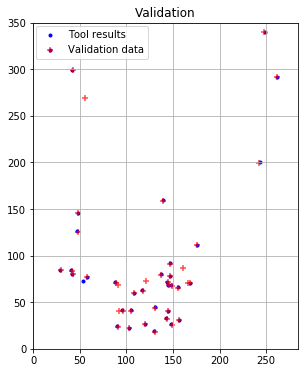

In [84]:
plt.figure(figsize=(9,6))
Tool_results = plt.scatter(coord[:,0],coord[:,1],marker='.',c = 'b', alpha = 1)
Validation = plt.scatter(x_validation,y_validation, marker='+', c = 'r', alpha = 0.7)
plt.legend([Tool_results , (Tool_results , Validation)], ["Tool results", "Validation data"],
           bbox_to_anchor=(0.01, 0.99), loc=2, borderaxespad=0.)
           #bbox_to_anchor=(0., 1.02, 1., .102), loc=3,
           #ncol=2,mode='expand', borderaxespad=0.)
plt.xlim(0, 284.)
plt.ylim(0, 350.)
plt.gca().set_aspect('equal', adjustable='box')
plt.title('Validation')
plt.grid()
plt.savefig('validation.png')

print('results data %d' % len(coord))
print('validation data %d' % len(x_validation))

In [85]:
reduced_coord[:,0]

array([569,  96, 600, 557, 319, 109, 108, 403, 335,  66,  94,  95, 335,
       314, 131, 202, 329, 123, 384, 356, 339, 332, 268, 248, 300, 218,
       330, 241, 327, 357, 339, 274, 235, 207, 297])

In [86]:
x_validation

array([29.690189277439, 48.1927710010604, 88.6402752340933,
       155.765920556999, 96.8158346003446, 130.378657261797,
       139.414801824496, 48.1927710010604, 42.1686746259279,
       42.5989672241517, 57.659208161983, 175.989672673515,
       146.7297759943, 148.450946387195, 117.469879315085,
       102.839930975477, 120.051634904427, 108.433734752386,
       105.42168656482, 131.239242458245, 92.0826160198833,
       91.2220308234358, 91.2220308234358, 120.912220100875,
       137.263338833378, 144.578313003181, 143.28743520851,
       144.148020404958, 145.438898199629, 148.450946387195,
       146.7297759943, 160.929431735684, 166.523235512593,
       168.674698503712, 156.196213155223, 247.848536576882,
       242.685025398197, 261.617899720042, 43.0292598223754,
       55.0774525726405], dtype=object)

### export

In [87]:
xy = pd.DataFrame({'X':coord[:,0],'Y':coord[:,1]})


In [88]:
with pd.ExcelWriter("komponent_1_output.xlsx") as writer:  # doctest: +SKIP
    xy.to_excel(writer,sheet_name='xy coordinates') 
    
writer.save()
writer.close()

## kmeans

In [89]:
case = case_0.copy()
case[case!=0]=1
case

array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       [0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       [0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       [0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       [0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       [0, 1, 1, 1, 1, 1, 1, 1, 1,

In [90]:
points = np.where(case==1)
points
case[points[0],points[1]]

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], dtype=u

In [91]:
pts = np.stack((points[1],points[0]),axis =-1)

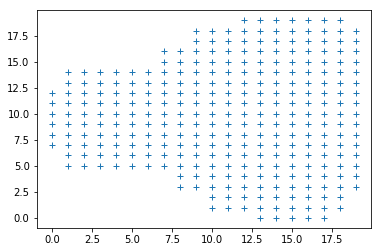

In [92]:
plt.plot(pts[:,0],pts[:,1],"+");

In [93]:
"""creation of the algo"""
kmeans=KMeans(n_clusters=2)
"""computation of centroids"""
kmeans.fit(pts)
"""here is the result"""
kmeans.cluster_centers_

array([[ 5.79365079,  9.72222222],
       [14.95348837,  9.70348837]])

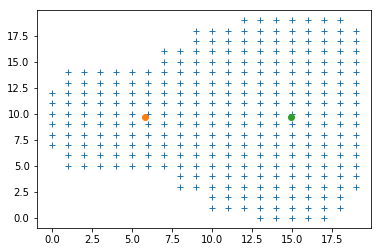

In [94]:
"""let's plot points and centroid"""

plt.plot(pts[:,0],pts[:,1],"+");
for centroid in kmeans.cluster_centers_:
    plt.plot(centroid[0],centroid[1],"o")

In [95]:
labels = kmeans.predict(pts)
labels

array([1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1,
       1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

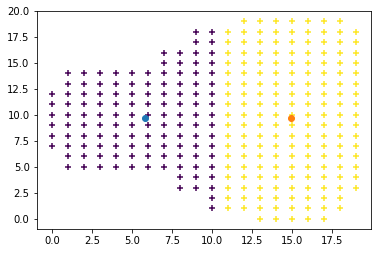

In [96]:
plt.scatter(pts[:,0],pts[:,1],c=labels,marker="+")
for centroid in kmeans.cluster_centers_:
    plt.plot(centroid[0],centroid[1],"o")